# Face Recognition


Downloaded from the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)", data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

This notebook uses images downloaded to produce an "average face", and performs k-means clustering to produce 20 centroids 
PCA is then used to observe the effect of number of components on the % variance.

Finally, deep learning is applied to compare its performance to k-means clustering.


In [1]:
# create dictionary to count number of images per individual

import os
import numpy as np

path, dirs, files = next(os.walk("./lfw_funneled"))
image_pername_dict = dict.fromkeys(dirs)

for i in dirs:
    path, dirs, files = next(os.walk("./lfw_funneled/" + str(i)))
    image_pername_dict[i] = len(files)

## Total number of images

In [2]:
sum(image_pername_dict.values())

13233

## Number of images per person

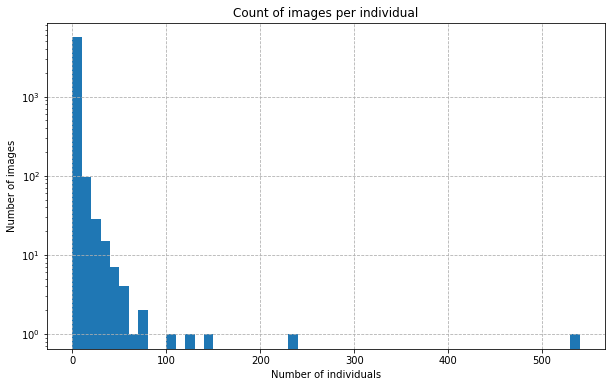

In [3]:
# plot histrogram for count of images per individual

import matplotlib.pyplot as plt
%matplotlib inline

num_imagespername = list(image_pername_dict.values())

plt.figure(figsize=(10,6))
plt.hist(num_imagespername, log=True, bins=range(0, 550, 10))
plt.grid(linestyle="--")
plt.title("Count of images per individual")
plt.ylabel("Number of images")
plt.xlabel("Number of individuals")
plt.show()

In [4]:
# determine individual with the most images

import operator

most_images = max(image_pername_dict.items(), key=operator.itemgetter(1))
print("{} has {} number of images - the most number of images.".format(most_images[0], most_images[1]))

George_W_Bush has 530 number of images - the most number of images.


## Filter to include only people with more than 10 images

In [5]:
# select only individuals with 10 or more images

image_10higher = dict()

for key, value in image_pername_dict.items():
    if value >= 10:
        image_10higher[key] = value

print(len(image_10higher))

158


There are a total of 158 individuals with 10 or more images, and their names along with corresponding number of images are stored in image_10higher dictionary.

## Display some image samples

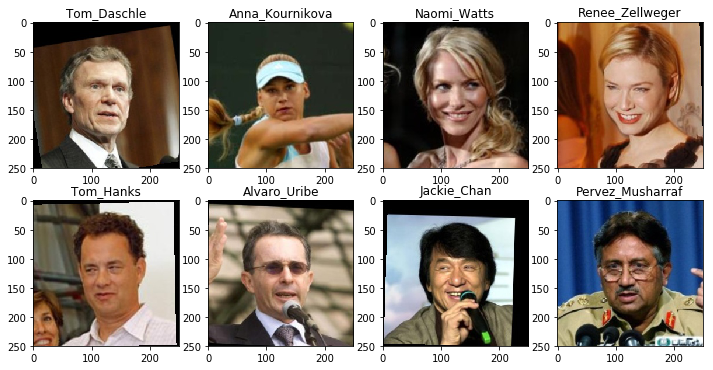

In [6]:
from PIL import Image
import random

fig = plt.figure(figsize=(12, 6))

random.seed(10)
random_samp = random.sample(range(0, 158), 8)       # select random individuals
name_list = list(image_10higher.keys())


count = 0
stacked_8 = []

for i in random_samp:
    name = name_list[i]
    name_path = "./lfw_funneled/" + str(name)
    path, dirs, files = next(os.walk(name_path))
    random_image = random.sample(range(0, len(files)), 1)        # select random image from inidividual
    open_image = Image.open(name_path + "/" + files[random_image[0]])
    ax = fig.add_subplot(2, 4, count+1)
    ax.imshow(open_image)
    ax.set_title(name)
    count += 1
    
    # stacking pixels of the images
    pix = np.array(open_image)
    stacked_8.append(pix)


## Average face from the above 8 images

Text(0.5,1,'Average face from the above 8 images')

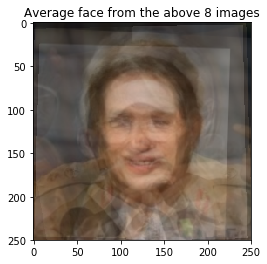

In [7]:
stacked_8 = np.array(stacked_8)
mean_8 = np.mean(stacked_8, axis=0).astype(int)
plt.imshow(mean_8)
plt.title("Average face from the above 8 images")

## Average face from all images 

In [8]:
name_list = list(image_10higher.keys())        # individuals with 10 or more images

pix_stack = []
count_file = 0

for name in name_list:
    name_path = "./lfw_funneled/" + str(name)
    
    for filename in os.listdir(name_path):
        file_path = name_path + "/" + str(filename)
        open_image = Image.open(file_path)
        pix = np.array(open_image)
        pix_stack.append(pix)

In [9]:
pix_stack = np.array(pix_stack)
pix_stack.shape

(4324, 250, 250, 3)

Text(0.5,1,'Average face from individuals with 10 or more images')

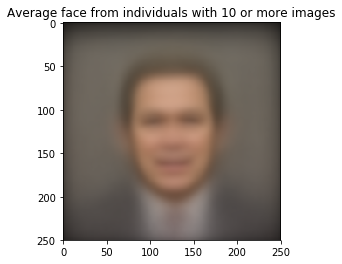

In [10]:
mean_pix = np.mean(pix_stack, axis=0).astype(int)
plt.imshow(mean_pix)
plt.title("Average face from individuals with 10 or more images")

## Display standard deviation of each pixel

In [11]:
std_pix = np.std(pix_stack, axis=0)
std_avg = np.mean(std_pix, axis=2)
std_avg.shape

(250, 250)

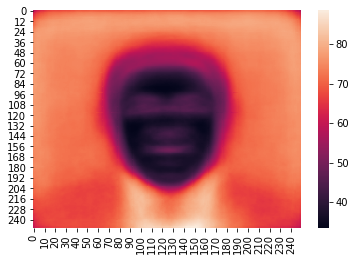

In [12]:
import seaborn as sns

sns.heatmap(std_avg)

The standard deviation of the features of the faces is higher than that of the background. Among the features of a face, the standard deviation of the hair, eyes, and mouth is lower than that of the skin.

## k-Means Clustering functions
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

In [13]:
from sklearn.metrics import pairwise_distances_argmin

In [14]:
def InitializeCentroids(X,k):
    
    num_data = X.shape[0]

    X_sample_idx = random.sample(range(0,num_data), k)
    centroids = [list(X[i]) for i in X_sample_idx]
    centroids = np.array(centroids)
    
    return centroids

In [15]:
def FindClosestCentroids(X, centroids):
    
    if X.shape[1] == 2:
        idx = pairwise_distances_argmin(X, centroids, axis=1, metric="euclidean")
    
    else:
        idx = []
        for row in X:
            result = [np.linalg.norm(row-s) for s in centroids]
            mindist_idx = result.index(min(result))
            idx.append(mindist_idx)
        idx = np.array(idx)
        
    return idx

In [16]:
from statistics import mean

def ComputeCentroidMeans(X, centroids, k):

    idx = FindClosestCentroids(X, centroids)
    new_centroids = []
    
    for i in range(k):
        indices = [j for j, x in enumerate(idx) if x == i]
        X_grp = [list(X[i]) for i in indices]
        X_grp = np.array(X_grp)
        cen = list(np.mean(X_grp, axis=0))

        new_centroids.append(cen)
    
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [17]:
def ClusterKM(X, k):
    # Randomly choose clusters
    centroids = InitializeCentroids(X,k)
    
    while True:
        # Assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids, k)
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, idx

### Check the above function

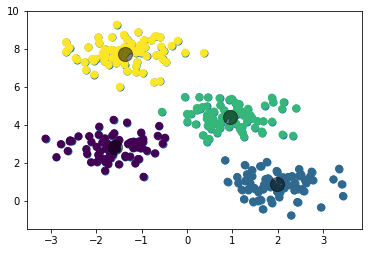

In [18]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

myCenters, myIdx = ClusterKM(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
plt.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5);

## Image centroids
Column 1: Image that represents the centroid for each of those clusters
<br>Column 2: Closest image in the original dataset to that centroid

In [19]:
import skimage.color

#### Normalize pixels

In [20]:
norm_pix = pix_stack / 255.0

In [21]:
X = norm_pix

In [22]:
myCenters, myIdx = ClusterKM(X, 20)

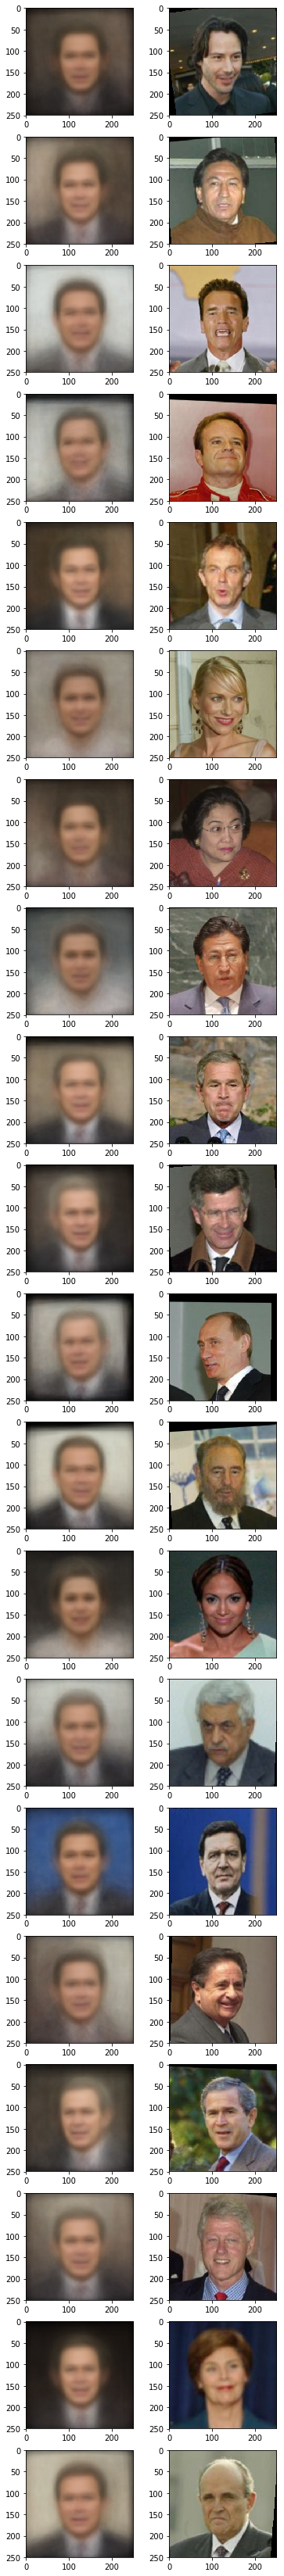

In [23]:
fig = plt.figure(figsize=(6,3*myCenters.shape[0]))

for each in range(myCenters.shape[0]):
    # centroids
    ax1 = fig.add_subplot(myCenters.shape[0], 2, (each*2)+1)
    ax1.imshow(myCenters[each])
    
    # images closest to each centroid
    cen_char = myCenters[each]
    X_indices = [i for i, x in enumerate(myIdx) if x == each]
    X_char = X[X_indices]
    dist_list = [np.linalg.norm(cen_char-match_x) for match_x in X_char]
    closest_x_idx = dist_list.index(min(dist_list))
    plot_eachx = X_char[closest_x_idx]
    
    ax2 = fig.add_subplot(myCenters.shape[0], 2, (each*2)+2)
    ax2.imshow(plot_eachx)
    

Some observations
* The clustering of images is highly dependent on the shade of the background color.
* Most of the cluster resembles a person wearing a shirt and a suit.
* Some of the closest image look pretty similar to the cluster it belongs to, while some do not.
* The clusters look like George W. Bush since 1/8 of the photos belong to him 

## Classify my photo!

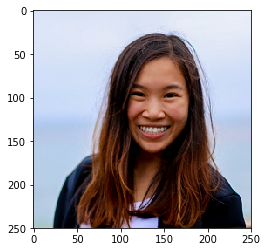

In [24]:
my_image = Image.open("myimage.jpg")
plt.imshow(my_image)

## My centroid

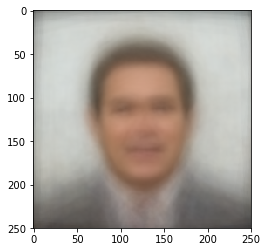

In [25]:
mypix = np.array(my_image) / 255.0
mypix = mypix[:,:,:3]         # somehow my image is 4D with the last layer having all 1.0s, so I trimmed it

cen_dist_list = [np.linalg.norm(c-mypix) for c in myCenters]
closest_cen_idx = cen_dist_list.index(min(cen_dist_list))
closest_cen_pix = myCenters[closest_cen_idx]
plt.imshow(closest_cen_pix)

## Closest image in the original dataset to my centroid

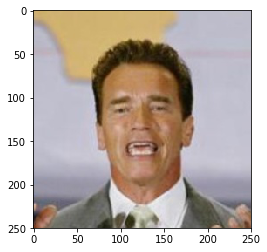

In [26]:
dist_list = [np.linalg.norm(closest_cen_pix-each_img) for each_img in X]
img_idx = dist_list.index(min(dist_list))

closest_img_tocen = X[img_idx]
plt.imshow(closest_img_tocen)

## Closest image in the original dataset to my photo

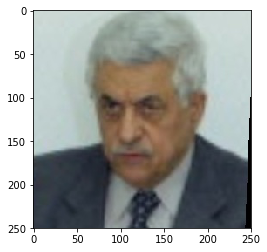

In [27]:
dist_list = [np.linalg.norm(mypix-each_img) for each_img in X]
img_idx = dist_list.index(min(dist_list))

closest_img_tome = X[img_idx]
plt.imshow(closest_img_tome)

## PCA with 1 to 100 components

In [29]:
shuffled = np.random.shuffle(X)
test = X[:int(X.shape[0]/2)]
train = X[int(X.shape[0]/2):]

In [30]:
# convert using rgb2grey
from skimage.color import rgb2grey, grey2rgb

test = rgb2grey(test)
train = rgb2grey(train)

In [31]:
train = train.reshape(train.shape[0], -1)
train.shape

(2162, 62500)

In [32]:
from sklearn.decomposition import PCA
from IPython.display import clear_output

num_components = list(range(1,101))
var_list = []

for i in range(1, 101):
    pca = PCA(n_components=i)
    pca.fit(train)
    var_ratio = pca.explained_variance_ratio_
    tot_var = np.sum(var_ratio)
    var_list.append(tot_var)
    
    clear_output()
    print("{} components PCA completed.".format(len(var_list)))
    

100 components PCA completed.


## Observe how variance changes with number of components

Text(0.5,1,'Graph of variance against number of components')

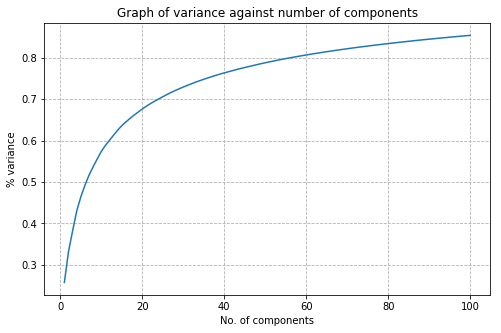

In [33]:
plt.figure(figsize=(8,5))
plt.plot(num_components, var_list)
plt.grid(linestyle=("--"))
plt.ylabel("% variance")
plt.xlabel("No. of components")
plt.title("Graph of variance against number of components")

Approximately 35 components are required to explain 75% of the variation in my original data.

## Display 10 first principal components (aka "eigenfaces")

In [34]:
top10 = pca.components_[:10]

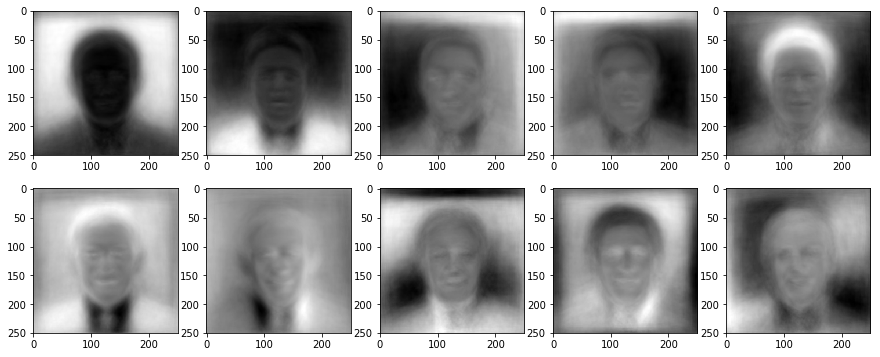

In [35]:
fig = plt.figure(figsize=(15,6))

position = 1

for each in top10:
    pix_2D = each.reshape(250,250)
    ax = fig.add_subplot(2, 5, position)
    ax.imshow(pix_2D, cmap="gray")
    position += 1
    

## Clustering processed images

In [36]:
grey_X = rgb2grey(X)
reshaped_X = grey_X.reshape(grey_X.shape[0], -1)
reshaped_X.shape

(4324, 62500)

### 1 Project images into 50-dimensional space defined by the first 50 principal components

In [37]:
# pca modelling
pca = PCA(n_components=50)
pca.fit(reshaped_X) # change back to X
fifty_comp = pca.components_[:50]
train_pca = pca.transform(train)

### 2 Perform k-means clustering (with k=20)

In [38]:
# clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20)
kmeans.fit(train_pca)
centers = kmeans.cluster_centers_

In [39]:
# converting back to original dimension
original_dim_centers = pca.inverse_transform(centers)
centers_2d = original_dim_centers.reshape(original_dim_centers.shape[0], 250, 250)

### 3 Display the 20 centroids

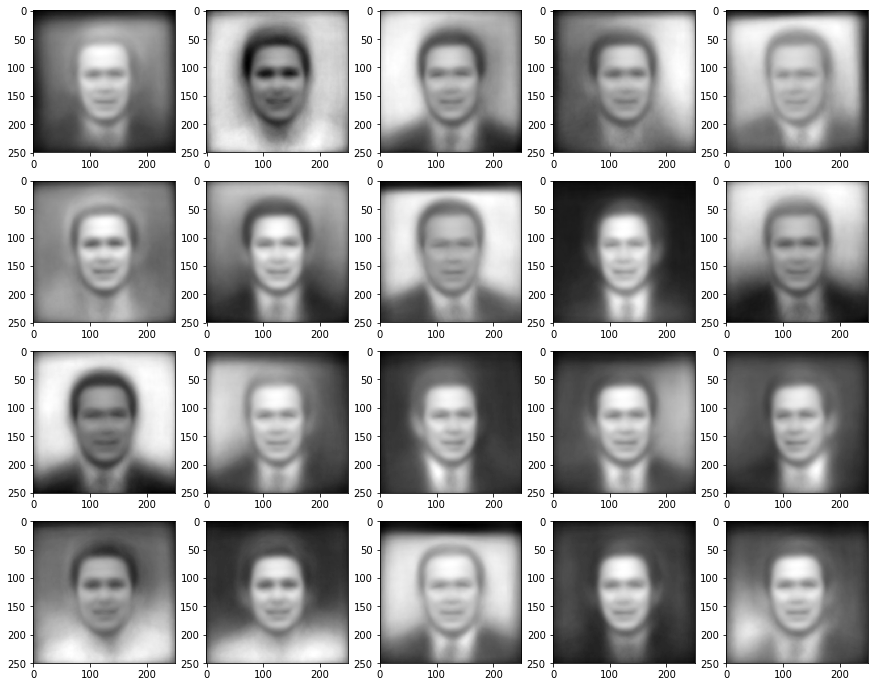

In [40]:
fig = plt.figure(figsize=(15,12))

for i in range(20):
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(centers_2d[i], cmap="gray")

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

## Comparing with and without PCA

#### Images displayed in the following order
Column 1: Original image 
<br>Column 2: Image after PCA
<br>Column 3: Nearest centroid
<br>Column 4: Image closest to centroi


In [41]:
# randomly select 8 images
random_samp_idx = random.sample(range(0, test.shape[0]), 8) 
select_test = test[random_samp_idx]

# jessica alba photo
second_image = Image.open("secondimage.jpg")
second_pix = np.array(second_image) / 255.0
second_grey = rgb2grey(second_pix)

# my photo
my_grey = rgb2grey(mypix)

In [42]:
# original images
combined_pix = np.concatenate([select_test, second_grey.reshape(1, 250, 250), my_grey.reshape(1, 250,250)], axis=0)

In [43]:
# project onto eigenface-space then revert back to original image space
reshape_combined = combined_pix.reshape(combined_pix.shape[0], -1)
pix_pca = pca.transform(reshape_combined)

original_dim_pix = pca.inverse_transform(pix_pca)
pix_2d = original_dim_pix.reshape(original_dim_pix.shape[0], 250, 250)

In [44]:
# find nearest centroid
combined_2d = combined_pix.reshape(combined_pix.shape[0], -1)
combined_pca = pca.transform(combined_2d)
nearest_cent = kmeans.predict(combined_pca)
nearest_cent_pca = centers[nearest_cent]
original_dim_cent = pca.inverse_transform(nearest_cent_pca)
original_dim_cent_2d = original_dim_cent.reshape(original_dim_cent.shape[0], 250, 250)

In [45]:
# recontruction image of closest training image to that centroid
from sklearn.metrics import pairwise_distances_argmin

trainclosest_idx = pairwise_distances_argmin(combined_pca, train_pca, axis=1, metric="euclidean")
closesttrain_pca = train_pca[trainclosest_idx]
original_dim_closest_train = pca.inverse_transform(closesttrain_pca)
original_dim_closest_train_2d = original_dim_closest_train.reshape(original_dim_closest_train.shape[0], 250, 250)

In [46]:
# original training image from above
closest_orig_train = train[trainclosest_idx]
closest_orig_train_2d = closest_orig_train.reshape(closest_orig_train.shape[0], 250, 250)

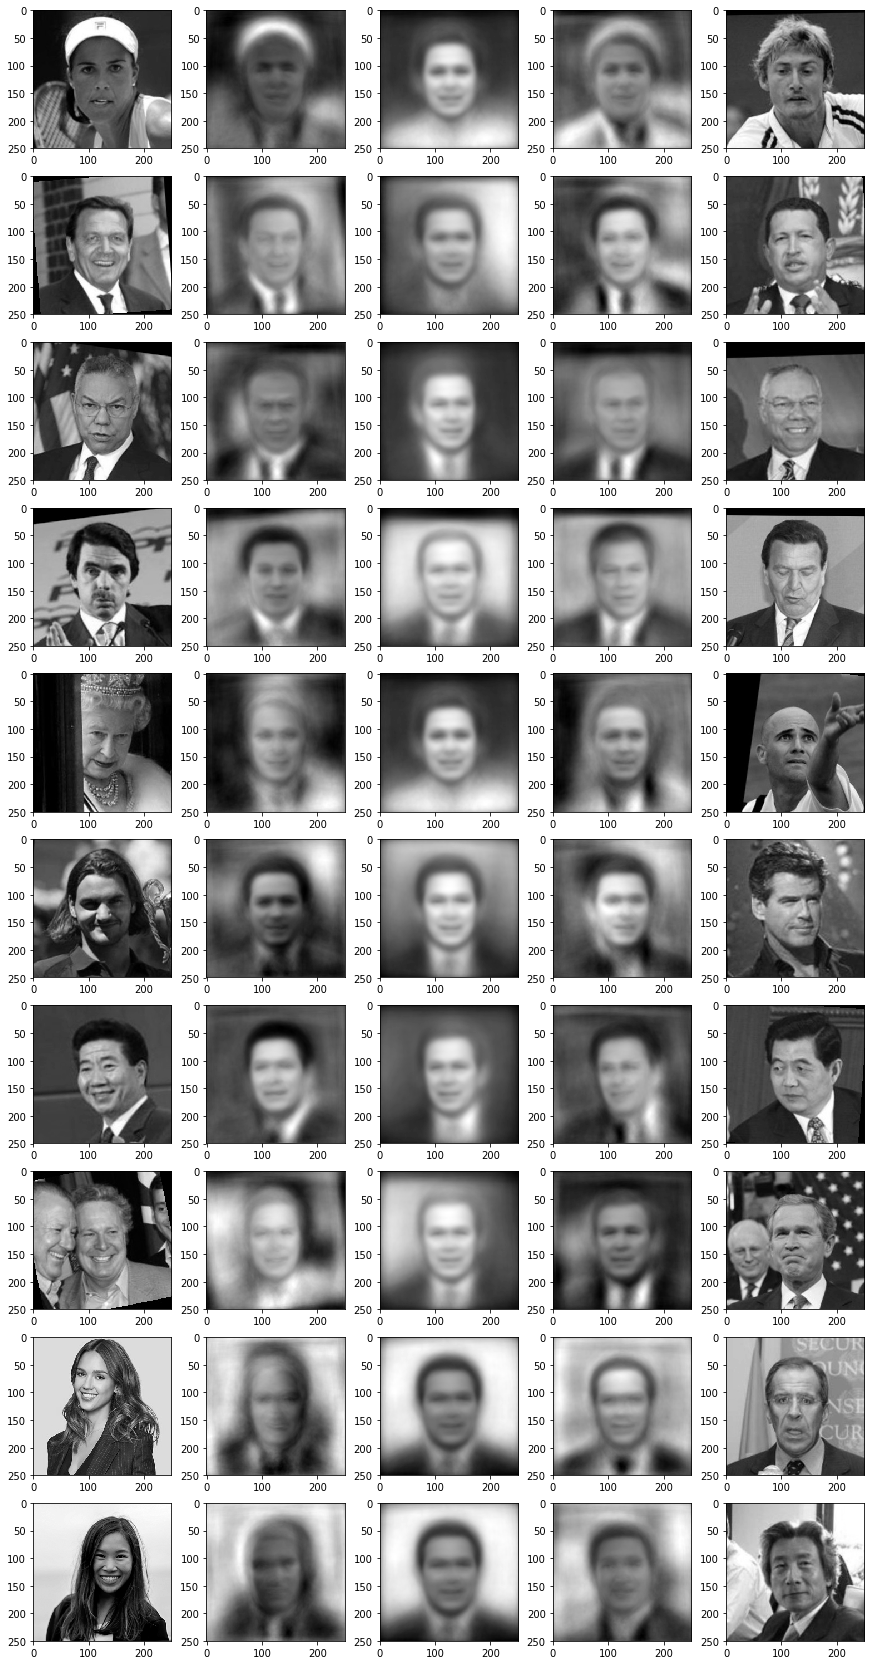

In [47]:
fig = plt.figure(figsize=(15,30))

for i in range(10):
    # original images
    ax1 = fig.add_subplot(10, 5, (i*5)+1)
    ax1.imshow(combined_pix[i], cmap="gray")
    
    # transformed images from pca
    ax2 = fig.add_subplot(10, 5, (i*5)+2)
    ax2.imshow(pix_2d[i], cmap="gray")
    
    # nearest centroid
    ax3 = fig.add_subplot(10, 5, (i*5)+3)
    ax3.imshow(original_dim_cent_2d[i], cmap="gray")
    
    # transformed version of photo closest to that centroid
    ax4 = fig.add_subplot(10, 5, (i*5)+4)
    ax4.imshow(original_dim_closest_train_2d[i], cmap="gray")
    
    # original photo closest to that centroid
    ax5 = fig.add_subplot(10, 5, (i*5)+5)
    ax5.imshow(closest_orig_train_2d[i], cmap="gray")

## Deep learning

In [48]:
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

model = InceptionV3(weights='imagenet')
bottleneck_model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)
bottleneck_model.summary()

C:\Users\Wei Tan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [49]:
def get_input_feature(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = bottleneck_model.predict(x)
    return features[0]

In [50]:
from tqdm import tqdm 

new_features = []

for name in tqdm(name_list):
    for image_this in os.listdir(os.path.join("./lfw_funneled/", name)):
        img_path = os.path.join("./lfw_funneled/", name, image_this)
        new_features.append(get_input_feature(img_path))

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [40:56<00:00, 12.26s/it]


In [51]:
new_features_array = np.array(new_features)
print(new_features_array.shape)

(4324, 2048)


In [52]:
myCenters_cnn, myIdx_cnn = ClusterKM(new_features_array, 20)

In [53]:
myCenters_cnn.shape, myIdx_cnn.shape

((20, 2048), (4324,))

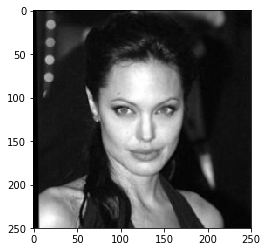

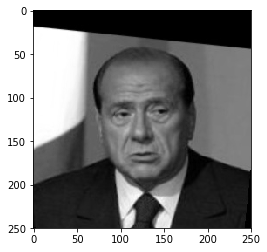

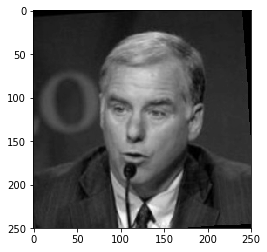

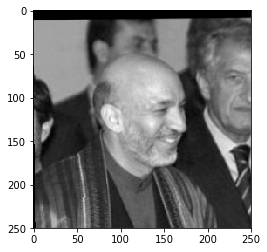

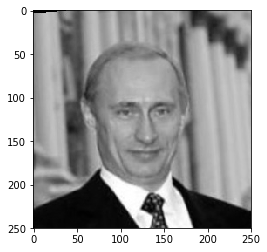

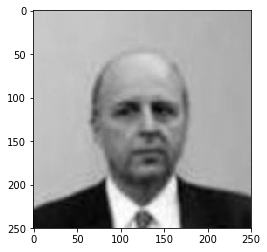

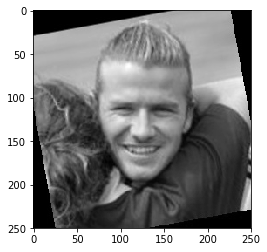

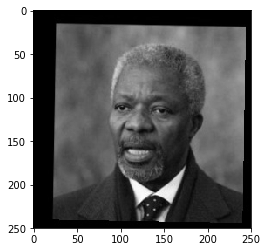

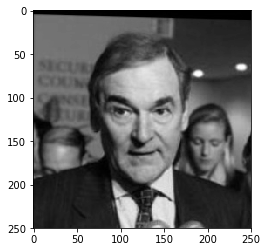

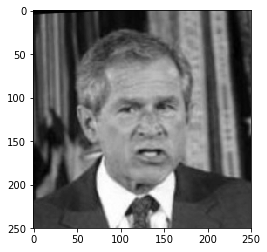

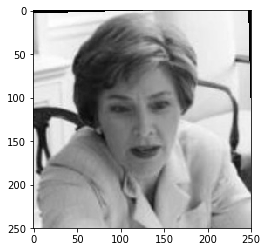

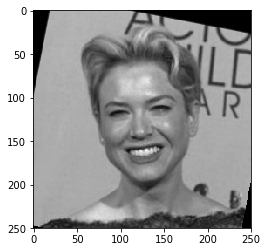

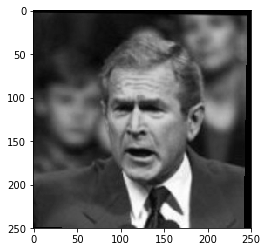

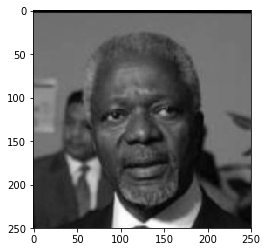

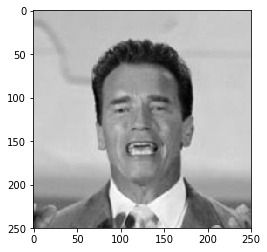

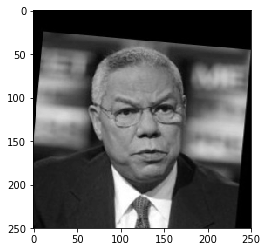

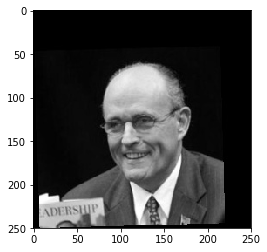

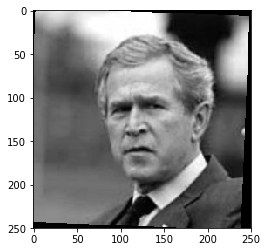

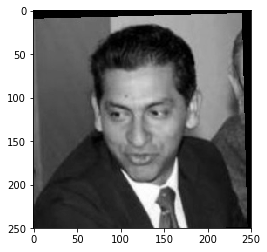

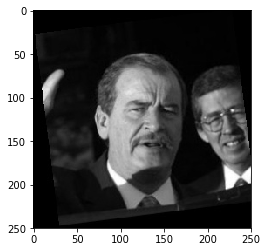

In [54]:
for i in range(myCenters_cnn.shape[0]):
    idx = pairwise_distances_argmin(myCenters_cnn[i].reshape(1, 2048), new_features_array, metric='euclidean')
    plt.imshow(reshaped_X[idx].reshape(250,250), cmap='gray')
    plt.show()

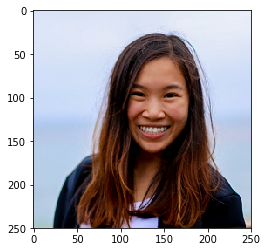

In [55]:
img = Image.open("myimage.jpg")
plt.imshow(img)

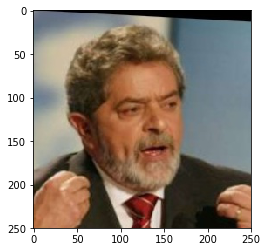

In [56]:
img_cnnfea = get_input_feature("myimage.jpg")

idx = pairwise_distances_argmin(img_cnnfea.reshape(1, 2048), myCenters_cnn, metric='euclidean')

# closest photo that belongs to my centroid 
idx = pairwise_distances_argmin(myCenters_cnn[idx], new_features_array)
plt.imshow(pix_stack[idx].reshape(250,250,3))

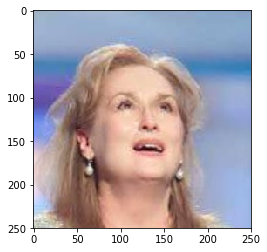

In [57]:
# my closest photo
idx = pairwise_distances_argmin(img_cnnfea.reshape(1,2048), new_features_array)
plt.imshow(pix_stack[idx].reshape(250,250,3))